In [1]:
import os

import pandas as pd
from pandas import Series, DataFrame
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

import sklearn.metrics
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Engineering

In [2]:
#Load the dataset
data = pd.read_csv("adult.data.txt", header=None)
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 
    'education-cat', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'capital-gain', 
    'capital-loss', 'hours-per-week', 'native-country',
    'pred_age'
]
data.columns = columns

In [3]:
# No empty data
# data_clean = data.dropna()

In [4]:
data.head(5) # First 5 rows

,age,workclass,fnlwgt,education,education-cat,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred_age
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Deleting age column because it simplifies classification too much
data.drop(['age'], inplace=True, axis=1)

# Is dublication of education-num column
data.drop(['education'], inplace=True, axis=1)

### Processing categorical variables

In [6]:
categorical_vars = (
    'workclass', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
)

# Transforming representation of categorical variables
for column in categorical_vars:
    data[column] = data[column].astype('category')
    data.insert(0, "{}-cat".format(column), data[column].cat.codes)
    data.drop([column], inplace=True, axis=1)

# First 5 rows
data.head(5)

,native-country-cat,sex-cat,race-cat,relationship-cat,occupation-cat,marital-status-cat,workclass-cat,fnlwgt,education-cat,capital-gain,capital-loss,hours-per-week,pred_age
0,39,1,4,1,1,4,7,77516,13,2174,0,40,<=50K
1,39,1,4,0,4,2,6,83311,13,0,0,13,<=50K
2,39,1,4,1,6,0,4,215646,9,0,0,40,<=50K
3,39,1,2,0,6,2,4,234721,7,0,0,40,<=50K
4,5,0,2,5,10,2,4,338409,13,0,0,40,<=50K


In [7]:
data.dtypes

native-country-cat      int8
sex-cat                 int8
race-cat                int8
relationship-cat        int8
occupation-cat          int8
marital-status-cat      int8
workclass-cat           int8
fnlwgt                 int64
education-cat          int64
capital-gain           int64
capital-loss           int64
hours-per-week         int64
pred_age              object
dtype: object

In [8]:
data.describe()

,native-country-cat,sex-cat,race-cat,relationship-cat,occupation-cat,marital-status-cat,workclass-cat,fnlwgt,education-cat,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,36.718866,0.669205,3.665858,1.446362,6.572740,2.611836,3.868892,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,7.823782,0.470506,0.848806,1.606771,4.228857,1.506222,1.455960,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,39.000000,0.000000,4.000000,0.000000,3.000000,2.000000,4.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,39.000000,1.000000,4.000000,1.000000,7.000000,2.000000,4.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,39.000000,1.000000,4.000000,3.000000,10.000000,4.000000,4.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,41.000000,1.000000,4.000000,5.000000,14.000000,6.000000,8.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### Modelling and prediction

In [9]:
predictors = data.iloc[:,:-1]
targets = data.iloc[:,-1]
pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, targets, test_size=.4)

In [10]:
# Training data
print(pred_train.shape)
print(tar_train.shape)

# Testing data
print(pred_test.shape)
print(tar_test.shape)

(19536, 12)
(19536,)
(13025, 12)
(13025,)


In [11]:
classifier=RandomForestClassifier(n_estimators=25)
classifier=classifier.fit(pred_train,tar_train)
predictions=classifier.predict(pred_test)

### Testing model

In [12]:
sklearn.metrics.confusion_matrix(tar_test,predictions)

array([[9062,  833],
       [1232, 1898]])

In [13]:
sklearn.metrics.accuracy_score(tar_test, predictions)

0.84145873320537423

### Build another model

In [14]:
model = ExtraTreesClassifier()
model.fit(pred_train,tar_train)
print(model.feature_importances_)

[ 0.01827676  0.02586035  0.01449437  0.07435485  0.07887664  0.10486144
  0.045189    0.27213958  0.13391176  0.09284858  0.03205675  0.10712992]


The **most importans feature** is 'fnlwgt'. Also 'education-cat', 'capital-gain', 'hours-per-week' contribute much<br>
The **least important features** 'native-country-cat' and 'race-cat'

### How number of trees contibute to accuracy of model

In [15]:
number_of_trees = 25
accuracy = []

for idx in range(number_of_trees):
   new_classifier = RandomForestClassifier(n_estimators=idx + 1)
   new_classifier = new_classifier.fit(pred_train,tar_train)
   new_predictions = new_classifier.predict(pred_test)
   accuracy.append(sklearn.metrics.accuracy_score(tar_test, new_predictions))

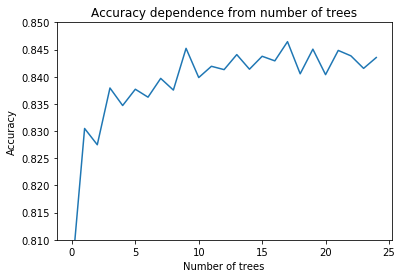

In [16]:
# configure axis and title
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title("Accuracy dependence from number of trees")

# configure  Y axes
plt.ylim(0.81,0.85)

plt.plot(range(number_of_trees), accuracy)
plt.show()